# python import

In [1]:
import os
import pandas as pd
import numpy as np
import lmfit
import glob
import platform
import json

from ipywidgets import interactive
from IPython.core.display import HTML
from IPython.display import display

import ipywidgets as widgets

import pprint

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib notebook

## Images size 

In [2]:
image_width = 9576
image_height = 6388
print(f"{image_height/2 =}")
print(f"number of pixels: {image_width * image_height:_}")
print(f"original image is 122MB")

image_height/2 =3194.0
number of pixels: 61_171_488
original image is 122MB


### theoretical center position 

In [3]:
perfect_center_x_px = 4869
perfect_center_y_px = 3216

### Pixel size 

this has been calculated by the notebook [calculation of pixel size](calculation_of_pixel_size.ipynb)

In [4]:
pixel_size = 51.010e-3  # mm   

### beam size 

In [5]:
beam_diameter_mm = 22.2157e1 # mm
beam_diameter_px = np.round(beam_diameter_mm / pixel_size)
print(f"{beam_diameter_px = }")
beam_radius_px = beam_diameter_px / 2
beam_radius_mm = beam_diameter_mm / 2

beam_diameter_px = 4355.0


# User input 

Define the **base folder (base_folder)** from where all the data set will be located. 

For example, if you are working on the analysis machine:

*top_folder = "/SNS/VENUS/IPTS-31716/shared/2023-06-12-analysis/"


In [6]:
if platform.node() == "mac113775":
    top_folder = "/Volumes/JeanHardDrive/SNS/VENUS/IPTS-31716/2023-06-12-analysis/"
elif platform.system() == "Linux":
    top_folder = "/SNS/VENUS/IPTS-31716/shared/2023-06-12-analysis"    
else:
    top_folder = "/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever"

### set up base folder 

In [7]:
base_folder = top_folder + "/profiles/beam_center_for_all_apertures"
assert os.path.exists(base_folder)  # making sure the base folder exists

# Loading all the profiles data

### retrieving list of files to load 

In [8]:
list_profile_files = glob.glob(base_folder + '/*.txt')
assert len(list_profile_files) > 0

## load profiles 

In [9]:
def cleaning_list_name_columns(list_name_columns):
    clean_list_name_columns = []
    for _index_column, _line in enumerate(list_name_columns):
        _line_no_space = _line.replace(" ", "")
        file_name, col_name = _line_no_space.split("->")
        various_part_of_file_name = file_name.split("/")
        clean_list_name_columns.append(various_part_of_file_name[-1])
    return clean_list_name_columns

raw_data_dict = {}
total_number_of_fitting_step = 0

for _file in list_profile_files:
    
    base_file_name = os.path.basename(_file)
    
    pd_data = pd.read_csv(_file, skiprows=26)
    pd_metadata = pd.read_csv(_file, skiprows=5, nrows=19)
    list_names_of_columns = list(pd_metadata.columns)
    list_label_columns = list(pd_metadata.loc[:, list_names_of_columns[0]])
    clean_list_label_columns = cleaning_list_name_columns(list_label_columns)
    
    list_names_of_columns = pd_data.columns
    xaxis = np.asarray(pd_data.loc[:, list_names_of_columns[0]])
    
    _dict = {}
    for _index, _col_name in enumerate(list_names_of_columns[1:]):
        profile = np.asarray(pd_data.loc[:, _col_name])
        _dict[clean_list_label_columns[_index]] = profile
        total_number_of_fitting_step += 1
    
    raw_data_dict[base_file_name] = {'profiles': _dict,
                                     'xaxis': xaxis}

the **raw_data_dict** is a dictionary that contains the profiles for all those files and the xaxis (pixel position) 

In [10]:
#raw_data_dict

# loading the beam center values calculated 

In [11]:
beam_center_file = os.path.join(top_folder, "beam_center.json")
assert os.path.exists(beam_center_file)

with open(beam_center_file, 'r') as openfile:
    master_profile_fitted_dict = json.load(openfile)

In [12]:
#master_profile_fitted_dict

# define keys


In [13]:
class Keys:  
    beam_center = "pixel coordinates of center"

## display the profiles fitted

<IPython.core.display.Javascript object>


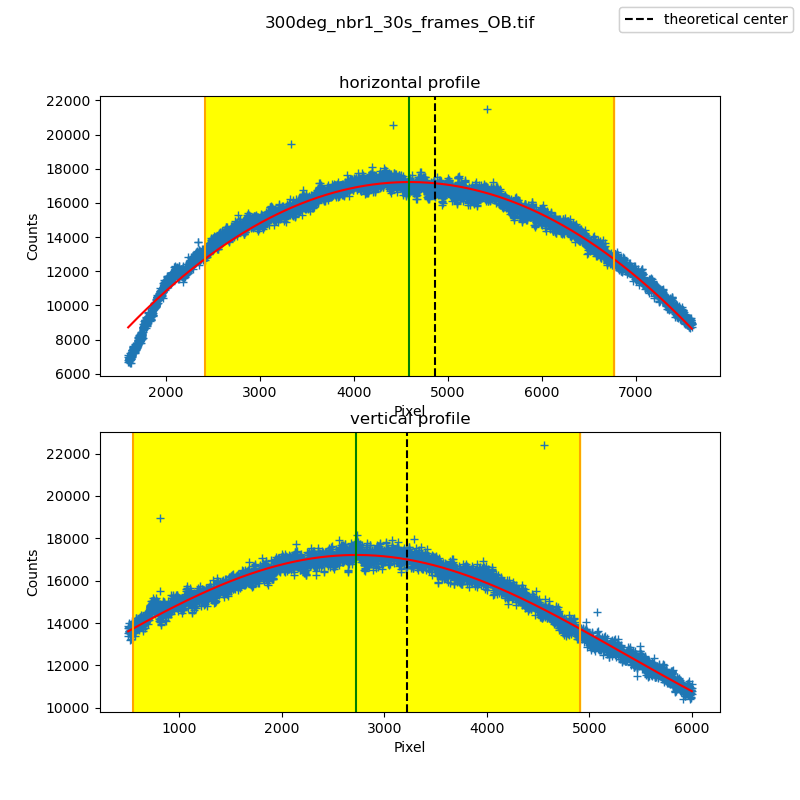

interactive(children=(Dropdown(description='aperture', layout=Layout(width='300px'), options=('0deg_30s_frames…

In [14]:
fig, axes = plt.subplots(num="experimental center (in pixel)", figsize=(8, 8), nrows=2, ncols=1)

title_label = widgets.Label("Experimental center (pixel):")
horizontal_center_value_ui = widgets.HBox([widgets.Label("Horizontal:",
                                                     layout=widgets.Layout(width="100px")),
                                           widgets.Label("N/A")])
horizontal_center_value = horizontal_center_value_ui.children[1]
vertical_center_value_ui = widgets.HBox([widgets.Label("Vertical:",
                                                     layout=widgets.Layout(width="100px")),
                                           widgets.Label("N/A")])
vertical_center_value = vertical_center_value_ui.children[1]

space = widgets.Label("")

theoretical_title_label = widgets.Label("Theoretical center (pixel):")
theoretical_horizontal_center_value_ui = widgets.HBox([widgets.Label("Horizontal:",
                                                     layout=widgets.Layout(width="100px")),
                                           widgets.Label(str(perfect_center_x_px))])
theoretical_horizontal_center_value = horizontal_center_value_ui.children[1]
theoretical_vertical_center_value_ui = widgets.HBox([widgets.Label("Vertical:",
                                                     layout=widgets.Layout(width="100px")),
                                           widgets.Label(str(perfect_center_y_px))])
theoretical_vertical_center_value = vertical_center_value_ui.children[1]


vertical_layout = widgets.VBox([title_label,
                               horizontal_center_value_ui,
                               vertical_center_value_ui,
                               space,
                               theoretical_title_label,
                               theoretical_horizontal_center_value_ui,
                               theoretical_vertical_center_value_ui,
                               ])

def plot(aperture):

    aperture_file_name = aperture
    fig.suptitle(aperture)
   
    # horizontal
    axes[0].clear()
    horizontal_xaxis = raw_data_dict['horizontal_profile.txt']['xaxis']
    horizontal_yaxis = raw_data_dict['horizontal_profile.txt']['profiles'][aperture_file_name]
    
    fitted_horizontal_yaxis = master_profile_fitted_dict[aperture_file_name]['fitting']['horizontal']
    center_value = master_profile_fitted_dict[aperture_file_name][Keys.beam_center]['x']
    horizontal_center_value.value = str(center_value)
    axes[0].plot(horizontal_xaxis, horizontal_yaxis, '+')
    axes[0].plot(horizontal_xaxis, fitted_horizontal_yaxis, 'r')
    axes[0].axvline(center_value, color='green')
    axes[0].set_title("horizontal profile")
    axes[0].set_xlabel("Pixel")
    axes[0].set_ylabel("Counts")
    
    # showing primary beam size
    axes[0].axvline(center_value - beam_radius_px, color='orange')
    axes[0].axvline(center_value + beam_radius_px, color='orange')
    axes[0].axvspan(center_value - beam_radius_px, center_value + beam_radius_px, color='yellow')
    
    # theoretical center
    axes[0].axvline(perfect_center_x_px, linestyle='--', color='black', label='theoretical center')
    fig.legend()
    
    # vertical
    axes[1].clear()
    vertical_xaxis = raw_data_dict['vertical_profile.txt']['xaxis']
    vertical_yaxis = raw_data_dict['vertical_profile.txt']['profiles'][aperture_file_name]
    
    fitted_vertical_yaxis = master_profile_fitted_dict[aperture_file_name]['fitting']['vertical']
    center_value = master_profile_fitted_dict[aperture_file_name][Keys.beam_center]['y']
    vertical_center_value.value = str(center_value)
    
    axes[1].plot(vertical_xaxis, vertical_yaxis, '+')
    axes[1].plot(vertical_xaxis, fitted_vertical_yaxis, 'r')
    axes[1].axvline(center_value, color='green')
    axes[1].set_title("vertical profile")
    axes[1].set_xlabel("Pixel")
    axes[1].set_ylabel("Counts")

    # showing primary beam size
    axes[1].axvline(center_value - beam_radius_px, color='orange')
    axes[1].axvline(center_value + beam_radius_px, color='orange')
    axes[1].axvspan(center_value - beam_radius_px, center_value + beam_radius_px, color='yellow')

    # theoretical center
    axes[1].axvline(perfect_center_y_px, linestyle='--', color='black')

    
display_profiles = interactive(plot,
                              aperture = widgets.Dropdown(options=clean_list_label_columns,
                                                         layout=widgets.Layout(width="300px")))
display(display_profiles) 
display(vertical_layout)
